In [1]:
import os

import pickle

import numpy as np

import pandas as pd

from tqdm.notebook import tqdm

from PIL import Image

import requests

from io import BytesIO

import matplotlib.pyplot as plt

import tensorflow

from tensorflow import keras

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model, load_model

from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Flatten



from transformers import BertTokenizer, BertModel

import json

from ultralytics.nn.tasks import DetectionModel

from ultralytics.nn.tasks import attempt_load_one_weight

In [2]:
print(tensorflow.__version__)
print(keras.__version__)

2.16.1
3.6.0


In [3]:
import tensorflow as tf

import torch

from tensorflow.keras.preprocessing.image import load_img, img_to_array



image = load_img("./img/01.jpg", target_size=(640, 640))

image_array = img_to_array(image)

image_array = image_array.reshape((1, image_array.shape[2], image_array.shape[0], image_array.shape[1]))

print(image_array.shape)

image_tensor = torch.from_numpy(image_array)

print(image_array.shape)

(1, 3, 640, 640)
(1, 3, 640, 640)


In [4]:
import torch

import cv2

from torchvision import transforms

from ultralytics import YOLO



# Hàm tiền xử lý ảnh thành tensor cho YOLO

def preprocess_image(image):

    preprocess = transforms.Compose([

        transforms.ToPILImage(),  # Chuyển từ numpy sang PIL

        transforms.Resize((640, 640)),  # Thay đổi kích thước ảnh về 640x640

        transforms.ToTensor(),  # Chuyển thành tensor

        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Chuẩn hóa theo chuẩn của ImageNet

    ])

    tensor_image = preprocess(image).unsqueeze(0)  # Thêm batch dimension

    return tensor_image

In [5]:
import torch

from ultralytics import YOLO



# Load the YOLOv8 model

model = YOLO('yolov8n.pt')



# Access the backbone layers

backbone = model.model.model[:10]  # Layers 0 to 9 form the backbone



# Create a new Sequential model with just the backbone layers

backbone_model = torch.nn.Sequential(*backbone)

In [6]:
# If you want to use the backbone for feature extraction

def extract_features(image):

    with torch.no_grad():

        features = backbone_model(image)

    return features

In [7]:
BASE_DIR = './output-feature'

WORKING_DIR = './output-feature'

In [8]:
# Load data from 220k-GPT4

data = pd.read_parquet("hf://datasets/laion/220k-GPT4Vision-captions-from-LIVIS/lvis_caption_url.parquet")
df = data.head(8000)
df[:5]

url  \
0  http://images.cocodataset.org/val2017/00000003...   
1  http://images.cocodataset.org/val2017/00000025...   
2  http://images.cocodataset.org/val2017/00000008...   
3  http://images.cocodataset.org/val2017/00000017...   
4  http://images.cocodataset.org/val2017/00000040...   

                                             caption  \
0  a kitchen with wooden cabinets on the walls, a...   
1  a street scene with construction scaffolding, ...   
2  multiple people wearing sweatshirts, a person ...   
3  a blue bicycle parked alongside a city street ...   
4  a bathroom with various objects, including a t...   

                                       short_caption  
0  Well-organized kitchen with wooden cabinets, a...  
1  Construction scaffolding, three individuals, s...  
2  Multiple people wearing sweatshirts, a person ...  
3  A blue bicycle in an urban setting, parked alo...  
4  A worn bathroom contains a toilet, sink, showe...

In [9]:
# load features from pickle
with open(os.path.join('./model/220k_GPT4_features_8000.pkl'), 'rb') as f:
  features = pickle.load(f)

In [10]:
features['http://images.cocodataset.org/val2017/000000037777.jpg'].size()

torch.Size([1, 256, 20, 20])

In [11]:
captions_doc = ""

for caption in df['caption']:

    captions_doc += caption + "\n"  # Thêm dấu xuống dòng giữa các caption nếu cần

In [12]:
def clean(mapping, start_end_token = True):

        for key, captions in mapping.items():

            for i in range(len(captions)):

                # take one caption at a time

                caption = captions[i]

                # preprocessing steps

                # convert to lowercase

                caption = caption.lower()

                # delete digits, special  chars, etc, ..

                caption = caption.replace('[^A-Za-z]', '')

                # delete additional spaces

                caption = caption.replace('\s+', ' ')

                if start_end_token == True:

                    # add start and end tags to the caption

                    caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'

                captions[i] = caption

        return mapping


In [13]:
# create mapping of image to captions

mapping = {}

# process lines

for index, row in tqdm(df.iterrows(), total=df.shape[0]):

  image_id = row['url']

  caption = row['caption']

  # remove extension from image ID

  image_id = image_id.split('.')[2]

  # create list if needed

  if image_id not in mapping:

    mapping[image_id] = []

  # store the caption

  mapping[image_id].append(caption)

  0%|          | 0/8000 [00:00<?, ?it/s]

In [14]:
# preprocess the text

clean(mapping)

{'org/val2017/000000037777': ['startseq kitchen with wooden cabinets on the walls, stove, multiple drawers, refrigerator, counter with fruits, and well-organized layout for cooking and storage needs. endseq'],
 'org/val2017/000000252219': ['startseq street scene with construction scaffolding, three individuals, shopping cart filled with personal belongings, street signs, and sidewalk. the construction scaffolding is blue and has text about the construction company and contact details. one individual is walking by, another person is standing and looking at something in their hands, and the third person is behind shopping cart going through the items inside. there are no vehicles visible in the image. the shopping cart filled with personal belongings might suggest that the individual using it is homeless or transient. the time of day appears to be daytime, but no direct indicators of weather conditions are present, although the presence of personal umbrellas might suggest rain. endseq'],

In [15]:
# after preprocess of text
mapping['org/val2017/000000153299']

['startseq two giraffes, one adult and one younger, standing close to each other near wooden structure. the giraffes are beautifully patterned with distinct patches. the environment suggests they might be in zoo or controlled environment made to resemble their natural habitat. the ground surface appears to be somewhat sandy, and the giraffes are in calm and relaxed posture. endseq']

In [16]:
all_captions = []

for key in mapping:

  for caption in mapping[key]:

    all_captions.append(caption)

In [17]:
# tokenize the text

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized_caption = tokenizer(all_captions, return_tensors='pt', padding=True, truncation=True)

vocab_size = tokenizer.vocab_size

In [18]:
vocab_size

30522

In [19]:
# get maximum length of the caption available

max_length = max(len(caption.split()) for caption in all_captions)

max_length

315

In [20]:
image_ids = list(mapping.keys())

split = int(len(image_ids) * 0.90) # Ti le 9-1

train = image_ids[:split]

test = image_ids[split:]

In [21]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical

import numpy as np



def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):

    X1, X2, y = list(), list(), list()

    n = 0

    while True:

        for key in data_keys:

            n += 1

            caption = mapping[key]  # lấy caption trực tiếp từ mapping với key



            # Encode the sequence using BertTokenizer

            encoded = tokenizer(caption, return_tensors='pt', padding=True, truncation=True, max_length=max_length) # Ensure padding and truncation are done correctly

            seq = encoded['input_ids'][0]  # Lấy input_ids từ tokenizer

            # Convert input_ids và attention_mask thành numpy arrays

            seq = np.array(seq)



            # split the sequence into X, y pairs

            for i in range(1, len(seq)):

                # split into input and output pairs

                in_seq, out_seq = seq[:i], seq[i]

                # pad input sequence

                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post') [0] # Pad sequences at the end



                # encode output sequence

                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                # store the sequences

                feature_key = 'http://images.cocodataset.' + key + '.jpg'

                X1.append(features[feature_key][0])

                X2.append(in_seq)

                y.append(out_seq)



            if n == batch_size:

                X1, X2, y = np.array(X1), np.array(X2), np.array(y)

                yield (X1, X2), y

                X1, X2, y = list(), list(), list()

                n = 0


In [22]:
def create_model(max_length, vocab_size):

    # image feature layers

    inputs1 = Input(shape=(256, 20, 20))  # Đầu vào có kích thước (256, 20, 20)

    fe1 = Flatten()(inputs1)  # Làm phẳng kích thước thành (None, 102400)

    fe1 = Dropout(0.4)(fe1)

    fe2 = Dense(256, activation='relu')(fe1)



    # sequence feature layers

    inputs2 = Input(shape=(max_length,))

    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)

    se2 = Dropout(0.4)(se1)

    se3 = LSTM(256, use_cudnn=False)(se2)



    # decoder model

    decoder1 = add([fe2, se3])

    decoder2 = Dense(256, activation='relu')(decoder1)

    outputs = Dense(vocab_size, activation='softmax')(decoder2)



    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    model.compile(loss='categorical_crossentropy', optimizer='adam')



    return model

In [23]:
model = create_model(max_length, vocab_size)

# plot the model

plot_model(model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [24]:
def idx_to_word(tensor_ids, tokenizer, bert=True):

    # Kiểm tra xem tensor_ids có phải là một tensor hay không

    if isinstance(tensor_ids, torch.Tensor):

        # Chuyển tensor thành list để xử lý từng phần tử

        tensor_ids = tensor_ids.tolist()



    # Kiểm tra nếu tensor_ids chỉ là một giá trị (như numpy.int64) và không thể lặp

    if isinstance(tensor_ids, (int, np.integer)):

        tensor_ids = [tensor_ids]  # Chuyển giá trị đơn thành danh sách



    words = []

    for integer in tensor_ids:

        if integer == 0:  # Bỏ qua nếu giá trị bằng 0 (giả sử 0 là token padding)

            continue

        # Decode từng token ID thành từ

        words.append(tokenizer.decode([integer], skip_special_tokens=True))

    

    return " ".join(words)

In [25]:
# Load model

model_path = './model/results/yolo_bert_lstm_8ep_cp-0001.weights.h5'



# Tạo lại mô hình giống như ban đầu

model = create_model(max_length, vocab_size)



# Tải trọng số từ tệp checkpoint

model.load_weights(model_path)

c:\Users\ptrieudai\.conda\envs\env-imcp-01\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [26]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 20,   │          0 │ -                 │
│ (InputLayer)        │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 315)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 102400)    │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 315, 256)  │  7,813,632 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 102400)    │          0 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 315, 256)  │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 315)       │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │ 26,214,656 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ dropout_3[0][0],  │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dense_3[0][0],    │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 30522)     │  7,844,154 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,463,546 (161.99 MB)

 Trainable params: 42,463,546 (161.99 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from PIL import Image

import cv2

# BERT predict caption

def predict_caption(model, image, tokenizer, max_length=20):

    in_text = ''  # Bắt đầu bằng chuỗi trống, không cần [CLS]

    for i in range(max_length):

        # encode the text using BERT tokenizer

        encoding = tokenizer.encode(in_text, add_special_tokens=False)  # Không thêm special tokens

        # pad encoding

        encoding = pad_sequences([encoding], maxlen=max_length, padding='post')

        # Convert encoding to int32

        encoding = tensorflow.cast(encoding, dtype=tensorflow.int32)



        # predict next word

        yhat = model.predict([image, encoding], verbose=0)

        # get index with highest probability

        yhat = np.argmax(yhat)

        # map integer to word

        word = idx_to_word(yhat, tokenizer, bert=True)



        if word is None:

            break  # Dừng lại nếu không tìm thấy từ hợp lệ

        # Avoid adding special tokens like [SEP]

        if word != '[SEP]':  # Chỉ thêm từ nếu không phải là [SEP]

            in_text += ' ' + word



        if word == '[SEP]':  # Dừng lại khi gặp token kết thúc [SEP]

            break



    return in_text.strip()  # Loại bỏ khoảng trắng thừa ở đầu/đuôi chuỗi

def get_customer_feature(url):

    # Đọc ảnh bằng PIL

    image = Image.open(url)



    # Chuyển đổi ảnh sang định dạng phù hợp cho mô hình

    image_rgb = image.convert('RGB')



    # Nếu cần chuyển đổi sang OpenCV để xử lý thêm, có thể dùng:

    image_cv = cv2.cvtColor(np.array(image_rgb), cv2.COLOR_RGB2BGR)



    # Tiếp tục xử lý ảnh...

    transformed_image = preprocess_image(image_cv)

    feature_matrix = extract_features(transformed_image)

    return feature_matrix



# Predict function


def generate_predict_caption(model, image_url, tokenizer, max_length):

    # Read Image

    image = Image.open(image_url)



    # Get Image Feature

    feature = get_customer_feature(image_url)

    # Predict the caption

    y_pred = predict_caption(model, feature, tokenizer, max_length)

    print('----------------------Predicted------------------')

    print(y_pred)

    plt.imshow(image)

----------------------Predicted------------------
the batter is in the midst of trick or maneuver . the background features trees , suggesting an outdoor setting , possibly park or park . the dynamics of the skier ##s balance , providing thermal protection , and insulation against ab ##m . ends ##e objects in the image include ski poles , ski poles , and ski poles . the presence of the skier ##s ##g ##uri . ends ##e ##rds or luggage , as well as the snow ##man . the skier ##s skills , foster ##ing , and the risk of injuries . ends ##e ##rds or luggage ##back , providing shade , and drama , depending on the power ##bar . ends ##e ##rds or ##ght aircraft , with the exception of the race being lifted from the same era . ends ##e ##to ##fer , as they are spinning , used for transporting goods . the presence of the skier ##s ##g ##uri , highlighting the changing journeys of accidents . ends ##e ##rds in the image , as well as the snow ##man . the skier ##s skills , foster ##ing , and the ri

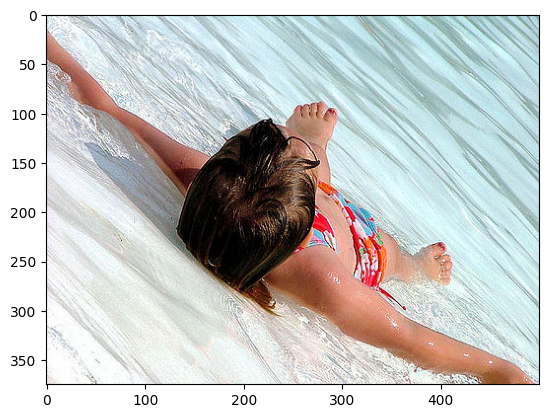

In [30]:
image_url = './data/Images/667626_18933d713e.jpg'

generate_predict_caption(model, image_url, tokenizer, max_length)

#### Predict image online


In [46]:
import requests

from PIL import Image

import numpy as np

import cv2

from io import BytesIO



# generate caption for an image

# BERT predict caption

def predict_caption(model, image_feature, tokenizer, max_length=20):

    in_text = ''  # Bắt đầu bằng chuỗi trống, không cần [CLS]

    for i in range(max_length):

        # encode the text using BERT tokenizer

        encoding = tokenizer.encode(in_text, add_special_tokens=False)  # Không thêm special tokens

        # pad encoding

        encoding = pad_sequences([encoding], maxlen=max_length, padding='post')

        # Convert encoding to int32

        encoding = tensorflow.cast(encoding, dtype=tensorflow.int32)

        # predict next word

        yhat = model.predict([image_feature, encoding], verbose=0)

        # get index with highest probability

        yhat = np.argmax(yhat)

        # map integer to word

        word = idx_to_word(yhat, tokenizer, bert=True)



        if word is None:

            break  # Dừng lại nếu không tìm thấy từ hợp lệ

        # Avoid adding special tokens like [SEP]

        if word != 'ends':  # Chỉ thêm từ nếu không phải là [SEP]

            in_text += ' ' + word


        if word == 'ends':  # Dừng lại khi gặp token kết thúc [SEP]

            break



    return in_text.strip()  # Loại bỏ khoảng trắng thừa ở đầu/đuôi chuỗi



def read_image_from_url(url):

  """

  Đọc hình ảnh từ URL và trả về đối tượng Image.

  Args:

    url: URL của hình ảnh.

  Returns:

    Đối tượng Image hoặc None nếu không thể đọc được hình ảnh.

  """

  try:

    response = requests.get(url)

    response.raise_for_status()  # Kiểm tra xem yêu cầu có thành công hay không

    img = Image.open(BytesIO(response.content))

    return img

  except requests.exceptions.RequestException as e:

    print(f"Lỗi khi tải hình ảnh từ {url}: {e}")

    return None





def get_feature(url):

    # load the image form file

    response = requests.get(url)

    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)



    # Đọc ảnh bằng OpenCV

    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)



    # Chuyển đổi từ BGR (OpenCV) sang RGB

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



    # Chuyển đổi ảnh thành định dạng tensor phù hợp cho mô hình

    transformed_image = preprocess_image(image_rgb)

    feature_matrix = extract_features(transformed_image)

    return feature_matrix





def generate_internet_caption(model, image_url, tokenizer, max_length):

    # Read Image

    image = read_image_from_url(image_url)

    

    # Get Image Feature

    feature = get_feature(image_url)

    # Predict the caption

    y_pred = predict_caption(model, feature, tokenizer, max_length)

    print('----------------------Predicted------------------')

    print(y_pred)

    plt.imshow(image)

In [47]:
image_url = 'https://20sfvn.com/wp-content/uploads/2022/08/thiet-ke-quan-cafe-tron-goi.jpeg'

image = read_image_from_url(image_url)

print(type(image))



image_array = np.array(image)

print(image_array.shape)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
(599, 899, 3)


----------------------Predicted------------------
load ##ing . the image does not show any other vehicles or people , and the time of day is likely midday or early afternoon .


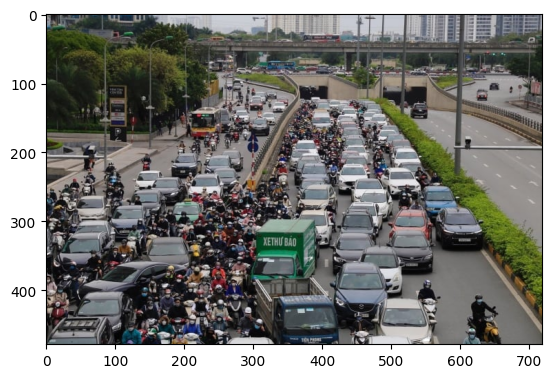

In [33]:
image_url = 'https://cdn-i.vtcnews.vn/resize/th/upload/2022/03/28/unzing1-10483786.jpg'

generate_internet_caption(model, image_url, tokenizer, max_length)

----------------------Predicted------------------
works ##pace , and the presence of the laptop computer , telephone , and the ##rm .


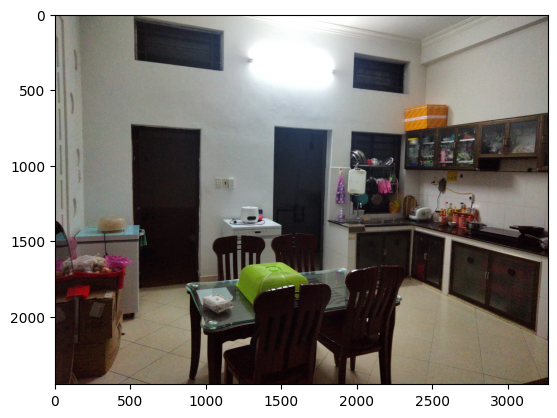

In [49]:
image_url = 'http://116.118.50.253:9000/mlflow/user_images/image_20241125104719.jpg'

generate_internet_caption(model, image_url, tokenizer, max_length)

#### Test with beamsearch


In [50]:
import requests

from PIL import Image

import numpy as np

import cv2

from io import BytesIO



def predict_caption_beam_search(model, image_feature, tokenizer, max_length=315, beam_width=10, max_words=30):

    # Khởi tạo danh sách các câu, mỗi câu là tuple (câu, điểm số)

    sequences = [('', 0.0)]  # Chuỗi ban đầu trống với điểm số bằng 0



    # Từ điển đếm số lần xuất hiện của từ

    word_count = {}



    # Lặp qua từng bước trong tối đa max_length bước

    for _ in range(max_length):

        all_candidates = []  # Danh sách các câu khả dĩ mới tại bước này

        

        # Duyệt qua từng câu trong danh sách beam width hiện tại

        for seq, score in sequences:

            # Kiểm tra nếu câu đã đạt đến giới hạn số từ hoặc chứa token kết thúc, thêm vào danh sách và bỏ qua việc mở rộng

            if len(seq.split()) >= max_words or '[EOS]' in seq:

                all_candidates.append((seq, score))

                continue



            # Encode câu hiện tại bằng BERT tokenizer

            encoding = tokenizer.encode(seq, add_special_tokens=False)

            # Pad encoding

            encoding = pad_sequences([encoding], maxlen=max_length, padding='post')

            # Convert encoding to int32

            encoding = tensorflow.cast(encoding, dtype=tensorflow.int32)



            # Dự đoán xác suất của từ tiếp theo

            yhat = model.predict([image_feature, encoding], verbose=0)

            # Lấy top từ có xác suất cao nhất (beam_width từ)

            top_indices = np.argsort(yhat[0])[-beam_width:]



            # Tạo các câu mới và tính toán điểm số cho từng từ được thêm

            for idx in top_indices:

                word = idx_to_word(idx, tokenizer, bert=True)

                if word is None:

                    continue

                if word.startswith('##'):  # Xử lý subword

                    word = word[2:]

                    new_seq = seq.rstrip() + word  # Nối vào từ trước

                else:

                    new_seq = seq + ' ' + word

                

                # Tăng số lần xuất hiện của từ trong từ điển đếm

                if word not in word_count:

                    word_count[word] = 0

                word_count[word] += 1



                # Penalization: Giảm điểm nếu từ đã xuất hiện nhiều lần

                repetition_penalty = 1.0 / (word_count[word] ** 0.5)

                

                # Normalization by length: chia log xác suất cho chiều dài câu

                new_score = score + (np.log(yhat[0][idx]) * repetition_penalty) / (len(new_seq.split()) + 1)

                all_candidates.append((new_seq, new_score))



        # Nếu không có ứng cử viên nào được tạo ra, dừng vòng lặp

        if not all_candidates:

            break



        # Sắp xếp tất cả các câu khả dĩ theo điểm số và chỉ giữ lại beam_width câu tốt nhất

        ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)

        sequences = ordered[:beam_width]



    # Kiểm tra nếu sequences trống

    if not sequences:

        return ""  # Trả về chuỗi rỗng nếu không có câu nào được tạo ra



    # Trả về câu có điểm số cao nhất trong danh sách beam width

    best_seq = sequences[0][0]

    return best_seq.strip()  # Loại bỏ khoảng trắng thừa





def read_image_from_url(url):

  """

  Đọc hình ảnh từ URL và trả về đối tượng Image.



  Args:

    url: URL của hình ảnh.



  Returns:

    Đối tượng Image hoặc None nếu không thể đọc được hình ảnh.

  """

  try:

    response = requests.get(url)

    response.raise_for_status()  # Kiểm tra xem yêu cầu có thành công hay không

    img = Image.open(BytesIO(response.content))

    return img

  except requests.exceptions.RequestException as e:

    print(f"Lỗi khi tải hình ảnh từ {url}: {e}")

    return None





def get_feature(url):

    # load the image form file

    response = requests.get(url)

    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)



    # Đọc ảnh bằng OpenCV

    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)



    # Chuyển đổi từ BGR (OpenCV) sang RGB

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



    # Chuyển đổi ảnh thành định dạng tensor phù hợp cho mô hình

    transformed_image = preprocess_image(image_rgb)

    feature_matrix = extract_features(transformed_image)

    return feature_matrix





def generate_internet_caption_beam_search(model, image_url, tokenizer, max_length):

    # Read Image

    image = read_image_from_url(image_url)

    

    # Get Image Feature

    feature = get_feature(image_url)

    # Predict the caption

    y_pred = predict_caption_beam_search(model, feature, tokenizer, max_length)

    print('----------------------Predicted------------------')

    print(y_pred)

    plt.imshow(image)

----------------------Predicted------------------
incidenteq an urban setting , possibly in an urban setting , with buildings in the background . in the foreground , there are multiple street signs , street signs ,


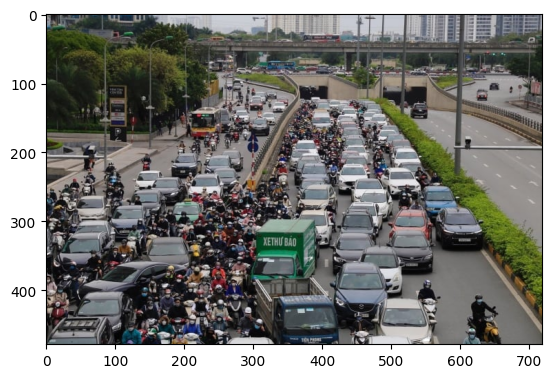

In [52]:
image_url = 'http://116.118.50.253:9000/mlflow/user_images/image_20241125104719.jpg'

generate_internet_caption_beam_search(model, image_url, tokenizer, max_length)

#### Beam search ap dung phat va xoa chuoi bi lap


In [53]:
def predict_caption_beam_search(model, image_feature, tokenizer, max_length=315, beam_width=3):

    # Khởi tạo danh sách các câu, mỗi câu là tuple (câu, điểm số)

    sequences = [('', 0.0)]  # Chuỗi ban đầu trống với điểm số bằng 0



    # Từ điển đếm số lần xuất hiện của từ

    word_count = {}



    # Danh sách các từ hoặc dấu câu không mong muốn ở đầu câu

    unwanted_start_tokens = {',', '.', 'and', 'or', 'frequent', 'reflect'}



    # Hàm kiểm tra lặp chuỗi con

    def has_repeated_substring(seq, min_length=4):

        words = seq.split()

        for i in range(len(words) - min_length + 1):

            substring = ' '.join(words[i:i + min_length])

            remaining_seq = ' '.join(words[i + min_length:])

            if substring in remaining_seq:

                return True

        return False



    # Vòng lặp sinh từ mới trong tối đa max_length bước

    for _ in range(max_length):

        all_candidates = []  # Danh sách các câu khả dĩ mới tại bước này



        # Duyệt qua từng câu trong danh sách beam width hiện tại

        for seq, score in sequences:

            # Kiểm tra nếu câu đã đạt đến giới hạn số từ hoặc chứa token kết thúc, thêm vào danh sách và bỏ qua việc mở rộng

            if len(seq.split()) >= max_length or '[EOS]' in seq:

                all_candidates.append((seq, score))

                continue



            # Encode câu hiện tại bằng BERT tokenizer

            encoding = tokenizer.encode(seq, add_special_tokens=False)

            # Pad encoding

            encoding = pad_sequences([encoding], maxlen=max_length, padding='post')

            # Convert encoding to int32

            encoding = tensorflow.cast(encoding, dtype=tensorflow.int32)



            # Dự đoán xác suất của từ tiếp theo

            yhat = model.predict([image_feature, encoding], verbose=0)

            # Lấy top từ có xác suất cao nhất (beam_width từ)

            top_indices = np.argsort(yhat[0])[-beam_width:]



            # Loại bỏ các từ đã xuất hiện nhiều hơn 2 lần trong câu

            top_indices = [idx for idx in top_indices if word_count.get(idx_to_word(idx, tokenizer, bert=True), 0) < 5]



            # Tạo các câu mới và tính toán điểm số cho từng từ được thêm

            for idx in top_indices:

                word = idx_to_word(idx, tokenizer, bert=True)

                if word is None:

                    continue

                if word.startswith('##'):  # Xử lý subword

                    word = word[2:]

                    new_seq = seq.rstrip() + word  # Nối vào từ trước

                else:

                    new_seq = seq + ' ' + word

                

                # Tăng số lần xuất hiện của từ trong từ điển đếm

                if word not in word_count:

                    word_count[word] = 0

                word_count[word] += 1



                # Kiểm tra nếu chuỗi có chuỗi con lặp lại

                # if has_repeated_substring(new_seq):

                #     continue  # Bỏ qua chuỗi này nếu có lặp chuỗi con



                # Kiểm tra từ đầu tiên

                first_word = new_seq.strip().split()[0]

                if first_word in unwanted_start_tokens:

                    continue  # Bỏ qua câu này nếu bắt đầu bằng từ không mong muốn



                # Penalization: Giảm điểm nếu từ đã xuất hiện nhiều lần

                repetition_penalty = 1.0 / (word_count[word] ** 100)

                

                # Normalization by length: chia log xác suất cho chiều dài câu

                new_score = score + (np.log(yhat[0][idx]) * repetition_penalty) / (len(new_seq.split()) + 1)

                all_candidates.append((new_seq, new_score))



        # Nếu không có ứng cử viên nào được tạo ra, dừng vòng lặp

        if not all_candidates:

            break



        # Sắp xếp tất cả các câu khả dĩ theo điểm số và chỉ giữ lại beam_width câu tốt nhất

        ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)

        sequences = ordered[:beam_width]



    # Kiểm tra nếu sequences trống

    if not sequences:

        return ""  # Trả về chuỗi rỗng nếu không có câu nào được tạo ra



    # Trả về câu có điểm số cao nhất trong danh sách beam width

    best_seq = sequences[0][0]

    return best_seq.strip()  # Loại bỏ khoảng trắng thừa


def read_image_from_url(url):

  """

  Đọc hình ảnh từ URL và trả về đối tượng Image.



  Args:

    url: URL của hình ảnh.



  Returns:

    Đối tượng Image hoặc None nếu không thể đọc được hình ảnh.

  """

  try:

    response = requests.get(url)

    response.raise_for_status()  # Kiểm tra xem yêu cầu có thành công hay không

    img = Image.open(BytesIO(response.content))

    return img

  except requests.exceptions.RequestException as e:

    print(f"Lỗi khi tải hình ảnh từ {url}: {e}")

    return None





def get_feature(url):

    # load the image form file

    response = requests.get(url)

    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)



    # Đọc ảnh bằng OpenCV

    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)



    # Chuyển đổi từ BGR (OpenCV) sang RGB

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



    # Chuyển đổi ảnh thành định dạng tensor phù hợp cho mô hình

    transformed_image = preprocess_image(image_rgb)

    feature_matrix = extract_features(transformed_image)

    return feature_matrix





def generate_internet_caption_beam_search(model, image_url, tokenizer, max_length):

    # Read Image

    image = read_image_from_url(image_url)

    

    # Get Image Feature

    feature = get_feature(image_url)

    # Predict the caption

    y_pred = predict_caption_beam_search(model, feature, tokenizer, max_length)

    print('----------------------Predicted------------------')

    print(y_pred)

    plt.imshow(image)

----------------------Predicted------------------
girafraf in girafraffe - covered covered with trees and trees . one of the elephants has the characteristic one on one hand . there 'raf one elephant visible on it


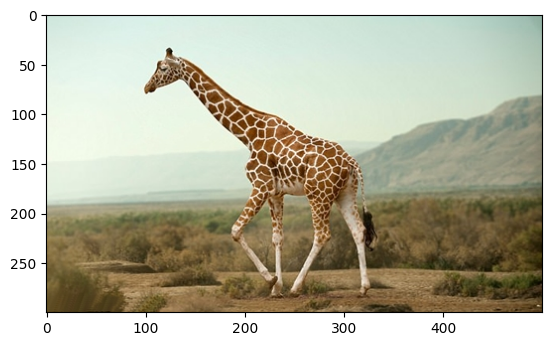

In [54]:
image_url = 'https://i-vnexpress.vnecdn.net/2017/09/20/Anh-4142-1505898813.jpg'

generate_internet_caption_beam_search(model, image_url, tokenizer, max_length)

#### Test ảnh local


In [56]:
def predict_caption_beam_search(model, image_feature, tokenizer, max_length=315, beam_width=5):

    # Khởi tạo danh sách các câu, mỗi câu là tuple (câu, điểm số)

    sequences = [('', 0.0)]  # Chuỗi ban đầu trống với điểm số bằng 0



    # Từ điển đếm số lần xuất hiện của từ

    word_count = {}



    # Danh sách các từ hoặc dấu câu không mong muốn ở đầu câu

    unwanted_start_tokens = {',', '.', 'and', 'or', 'frequent', 'reflect'}



    # Hàm kiểm tra lặp chuỗi con

    def has_repeated_substring(seq, min_length=4):

        words = seq.split()

        for i in range(len(words) - min_length + 1):

            substring = ' '.join(words[i:i + min_length])

            remaining_seq = ' '.join(words[i + min_length:])

            if substring in remaining_seq:

                return True

        return False



    # Vòng lặp sinh từ mới trong tối đa max_length bước

    for _ in range(max_length):

        all_candidates = []  # Danh sách các câu khả dĩ mới tại bước này



        # Duyệt qua từng câu trong danh sách beam width hiện tại

        for seq, score in sequences:

            # Kiểm tra nếu câu đã đạt đến giới hạn số từ hoặc chứa token kết thúc, thêm vào danh sách và bỏ qua việc mở rộng

            if len(seq.split()) >= max_length or '[EOS]' in seq:

                all_candidates.append((seq, score))

                continue



            # Encode câu hiện tại bằng BERT tokenizer

            encoding = tokenizer.encode(seq, add_special_tokens=False)

            # Pad encoding

            encoding = pad_sequences([encoding], maxlen=max_length, padding='post')

            # Convert encoding to int32

            encoding = tensorflow.cast(encoding, dtype=tensorflow.int32)



            # Dự đoán xác suất của từ tiếp theo

            yhat = model.predict([image_feature, encoding], verbose=0)

            # Lấy top từ có xác suất cao nhất (beam_width từ)

            top_indices = np.argsort(yhat[0])[-beam_width:]



            # Loại bỏ các từ đã xuất hiện nhiều hơn 2 lần trong câu

            top_indices = [idx for idx in top_indices if word_count.get(idx_to_word(idx, tokenizer, bert=True), 0) < 5]



            # Tạo các câu mới và tính toán điểm số cho từng từ được thêm

            for idx in top_indices:

                word = idx_to_word(idx, tokenizer, bert=True)

                if word is None:

                    continue

                if word.startswith('##'):  # Xử lý subword

                    word = word[2:]

                    new_seq = seq.rstrip() + word  # Nối vào từ trước

                else:

                    new_seq = seq + ' ' + word

                

                # Tăng số lần xuất hiện của từ trong từ điển đếm

                if word not in word_count:

                    word_count[word] = 0

                word_count[word] += 1



                # Kiểm tra nếu chuỗi có chuỗi con lặp lại

                # if has_repeated_substring(new_seq):

                #     continue  # Bỏ qua chuỗi này nếu có lặp chuỗi con



                # Kiểm tra từ đầu tiên

                first_word = new_seq.strip().split()[0]

                if first_word in unwanted_start_tokens:

                    continue  # Bỏ qua câu này nếu bắt đầu bằng từ không mong muốn



                # Penalization: Giảm điểm nếu từ đã xuất hiện nhiều lần

                repetition_penalty = 1.0 / (word_count[word] ** 10)

                

                # Normalization by length: chia log xác suất cho chiều dài câu

                new_score = score + (np.log(yhat[0][idx]) * repetition_penalty) / (len(new_seq.split()) + 1)

                all_candidates.append((new_seq, new_score))



        # Nếu không có ứng cử viên nào được tạo ra, dừng vòng lặp

        if not all_candidates:

            break



        # Sắp xếp tất cả các câu khả dĩ theo điểm số và chỉ giữ lại beam_width câu tốt nhất

        ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)

        sequences = ordered[:beam_width]



    # Kiểm tra nếu sequences trống

    if not sequences:

        return ""  # Trả về chuỗi rỗng nếu không có câu nào được tạo ra



    # Trả về câu có điểm số cao nhất trong danh sách beam width

    best_seq = sequences[0][0]

    return best_seq.strip()  # Loại bỏ khoảng trắng thừa

In [57]:
from PIL import Image

import cv2



def get_customer_feature(url):

    # Đọc ảnh bằng PIL

    image = Image.open(url)



    # Chuyển đổi ảnh sang định dạng phù hợp cho mô hình

    image_rgb = image.convert('RGB')



    # Nếu cần chuyển đổi sang OpenCV để xử lý thêm, có thể dùng:

    image_cv = cv2.cvtColor(np.array(image_rgb), cv2.COLOR_RGB2BGR)



    # Tiếp tục xử lý ảnh...

    transformed_image = preprocess_image(image_cv)

    feature_matrix = extract_features(transformed_image)

    return feature_matrix



# Predict function
def generate_predict_caption(model, image_url, tokenizer, max_length):

    # Read Image

    image = Image.open(image_url)

    # Get Image Feature

    feature = get_customer_feature(image_url)

    # Predict the caption

    y_pred = predict_caption_beam_search(model, feature, tokenizer)

    print('----------------------Predicted------------------')

    print(y_pred)

    plt.imshow(image)

----------------------Predicted------------------
zebra in the girafraf setting appears to the natural environment . one giraffes appear relaxed or at ease on their body of natural habitat


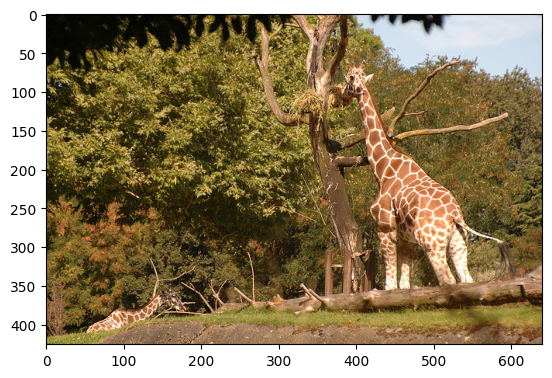

In [59]:
# Predict

image_url = './data/image/000000000025.jpg'

generate_predict_caption(model, image_url, tokenizer, max_length)

#### Beam Search áp dụng phạt ng-ram


In [61]:
# Áp dụng phạt theo Ng-ram

def predict_caption_beam_search(model, image_feature, tokenizer, max_length=315, beam_width=5, max_words=30522):

    sequences = [('', 0.0)]

    word_count = {}



    def has_repeated_ngram(seq, n=2):

        words = seq.split()

        ngrams = [' '.join(words[i:i + n]) for i in range(len(words) - n + 1)]

        return len(ngrams) != len(set(ngrams))



    for _ in range(max_length):

        all_candidates = []

        

        for seq, score in sequences:

            if len(seq.split()) >= max_words:# or '[EOS]' in seq:

                all_candidates.append((seq, score))

                continue



            encoding = tokenizer.encode(seq, add_special_tokens=False)

            encoding = pad_sequences([encoding], maxlen=max_length, padding='post')

            encoding = tensorflow.cast(encoding, dtype=tensorflow.int32)



            yhat = model.predict([image_feature, encoding], verbose=0)

            top_indices = np.argsort(yhat[0])[-beam_width:]

            

            



            for idx in top_indices:

                word = idx_to_word(idx, tokenizer, bert=True)

                if word is None:

                    continue

                if word.startswith('##'):

                    word = word[2:]

                    new_seq = seq.rstrip() + word

                else:

                    new_seq = seq + ' ' + word



                if word not in word_count:

                    word_count[word] = 0

                word_count[word] += 1



                # Phạt

                repetition_penalty = 1.0 / (word_count[word] ** 0.75)

                new_score = score + (np.log(yhat[0][idx]) * repetition_penalty) / (len(new_seq.split()) + 1)



                if has_repeated_ngram(new_seq, n=2):

                    continue



                all_candidates.append((new_seq, new_score))



        if not all_candidates:

            break



        ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)

        sequences = ordered[:beam_width]



    if not sequences:

        return ""



    best_seq = sequences[0][0]

    return best_seq.strip()



def read_image_from_url(url):

  """

  Đọc hình ảnh từ URL và trả về đối tượng Image.



  Args:

    url: URL của hình ảnh.



  Returns:

    Đối tượng Image hoặc None nếu không thể đọc được hình ảnh.

  """

  try:

    response = requests.get(url)

    response.raise_for_status()  # Kiểm tra xem yêu cầu có thành công hay không

    img = Image.open(BytesIO(response.content))

    return img

  except requests.exceptions.RequestException as e:

    print(f"Lỗi khi tải hình ảnh từ {url}: {e}")

    return None





def get_feature(url):

    # load the image form file

    response = requests.get(url)

    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)



    # Đọc ảnh bằng OpenCV

    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)



    # Chuyển đổi từ BGR (OpenCV) sang RGB

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



    # Chuyển đổi ảnh thành định dạng tensor phù hợp cho mô hình

    transformed_image = preprocess_image(image_rgb)

    feature_matrix = extract_features(transformed_image)

    return feature_matrix





def generate_internet_caption_beam_search(model, image_url, tokenizer, max_length):

    # Read Image

    image = read_image_from_url(image_url)

    

    # Get Image Feature

    feature = get_feature(image_url)

    # Predict the caption

    y_pred = predict_caption_beam_search(model, feature, tokenizer, max_length)

    print('----------------------Predicted------------------')

    print(y_pred)

    plt.imshow(image)

----------------------Predicted------------------
sandwich , fork , and napkins . the setting appears to be an indoor setting , possibly in an outdoor setting or an open space . endseq


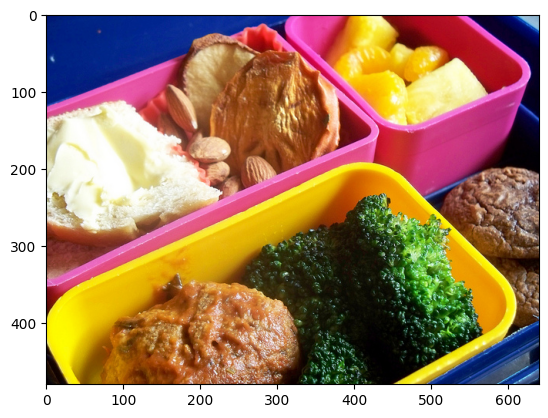

In [62]:
# Predict

image_url = './data/image/000000000009.jpg'

generate_predict_caption(model, image_url, tokenizer, max_length)

----------------------Predicted------------------
man ' s person wearing dress with red shirt and red necktie . the man is wearing blue shirt , and the person is in the background , with the woman wearing jeans , necktie , bracelet and bracelet , ring on the shirt . there are no other people or animals visible . endseq


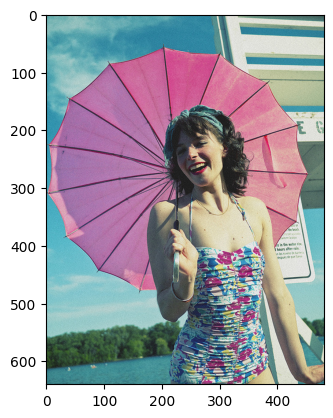

In [63]:
image_url = './data/image/000000000036.jpg'

generate_predict_caption(model, image_url, tokenizer, max_length)